In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_DO(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=5, filters=64, strides=1, padding='same', 
                      activation='tanh', input_shape=input_shape)) 
#     model.add(BatchNormalization())
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=5, filters=64*(2**int((i+1)/4)), strides=1, padding='same', 
                          activation='tanh'))
#         model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_DO(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         384       
_________________________________________________________________
flatten (Flatten)            (None, 1024000)           0         
_________________________________________________________________
dropout (Dropout)            (None, 1024000)           0         
_________________________________________________________________
dense (Dense)                (None, 16)                16384016  
Total params: 16,384,400
Trainable params: 16,384,400
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (ty

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_21 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 5333, 64)          20544     
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 1777, 64)          0         
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 1777, 64)          20544     
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 592, 64)           0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36736/36805 [============================>.] - ETA: 0s - loss: 2.7442 - acc: 0.1056
Epoch 00001: val_loss improved from inf to 2.73636, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_1_conv_checkpoint/001-2.7364.hdf5
36805/36805 [==============================] - 29s 792us/sample - loss: 2.7439 - acc: 0.1058 - val_loss: 2.7364 - val_acc: 0.0948
Epoch 2/500
36736/36805 [============================>.] - ETA: 0s - loss: 2.4984 - acc: 0.2538
Epoch 00002: val_loss did not improve from 2.73636
36805/36805 [==============================] - 27s 742us/sample - loss: 2.4984 - acc: 0.2537 - val_loss: 2.8121 - val_acc: 0.1088
Epoch 3/500
36736/36805 [============================>.] - ETA: 0s - loss: 2.2571 - acc: 0.3409
Epoch 00003: val_loss did not improve from 2.73636
36805/36805 [==============================] - 27s 736us/sample - loss: 2.2575 - acc: 0.3408 - val_loss: 2.9320 

36736/36805 [============================>.] - ETA: 0s - loss: 0.6720 - acc: 0.8191
Epoch 00029: val_loss did not improve from 2.73636
36805/36805 [==============================] - 27s 734us/sample - loss: 0.6721 - acc: 0.8190 - val_loss: 6.4180 - val_acc: 0.1085
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6545 - acc: 0.8241
Epoch 00030: val_loss did not improve from 2.73636
36805/36805 [==============================] - 27s 733us/sample - loss: 0.6546 - acc: 0.8241 - val_loss: 6.5308 - val_acc: 0.1081
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6373 - acc: 0.8273
Epoch 00031: val_loss did not improve from 2.73636
36805/36805 [==============================] - 27s 731us/sample - loss: 0.6373 - acc: 0.8273 - val_loss: 6.6096 - val_acc: 0.1060
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6206 - acc: 0.8329
Epoch 00032: val_loss did not improve from 2.73636
36805/36805 [==================

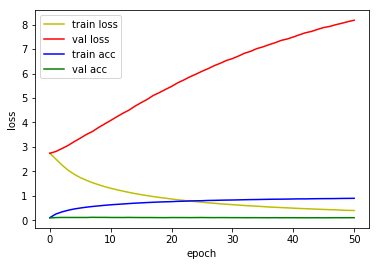

4815/4815 [==============================] - 1s 302us/sample - loss: 2.7258 - acc: 0.0993
Loss: 2.7257815188707966 Accuracy: 0.09927311

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3412 - acc: 0.2642
Epoch 00001: val_loss improved from inf to 2.12429, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_2_conv_checkpoint/001-2.1243.hdf5
36805/36805 [==============================] - 43s 1ms/sample - loss: 2.3413 - acc: 0.2642 - val_loss: 2.1243 - val_acc: 0.3387
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8159 - acc: 0.4388
Epoch 00002: val_loss improved from 2.12429 to 2.06053, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_2_conv_checkpoint/002-2.0605.hdf5
36805/36805 [==============================] - 42s 1ms/sample - loss: 1.8158 - acc: 0.4389 - val_loss: 2.0605 - val_acc: 0.3524
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.530

Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2019 - acc: 0.9372
Epoch 00030: val_loss did not improve from 2.06053
36805/36805 [==============================] - 42s 1ms/sample - loss: 0.2019 - acc: 0.9372 - val_loss: 4.4486 - val_acc: 0.3454
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1932 - acc: 0.9392
Epoch 00031: val_loss did not improve from 2.06053
36805/36805 [==============================] - 42s 1ms/sample - loss: 0.1932 - acc: 0.9391 - val_loss: 4.4882 - val_acc: 0.3494
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1934 - acc: 0.9389
Epoch 00032: val_loss did not improve from 2.06053
36805/36805 [==============================] - 42s 1ms/sample - loss: 0.1935 - acc: 0.9389 - val_loss: 4.5684 - val_acc: 0.3494
Epoch 33/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1855 - acc: 0.9433
Epoch 00033: val_loss did not improve from 2.06053
36805/36805 [===========

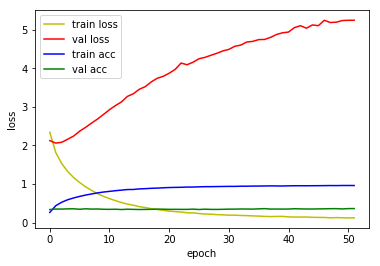

4815/4815 [==============================] - 2s 498us/sample - loss: 2.0970 - acc: 0.3396
Loss: 2.096959860401609 Accuracy: 0.33956388

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0410 - acc: 0.3536
Epoch 00001: val_loss improved from inf to 1.65322, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_3_conv_checkpoint/001-1.6532.hdf5
36805/36805 [==============================] - 48s 1ms/sample - loss: 2.0410 - acc: 0.3536 - val_loss: 1.6532 - val_acc: 0.4952
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4554 - acc: 0.5478
Epoch 00002: val_loss improved from 1.65322 to 1.54845, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_3_conv_checkpoint/002-1.5484.hdf5
36805/36805 [==============================] - 47s 1ms/sample - loss: 1.4554 - acc: 0.5478 - val_loss: 1.5484 - val_acc: 0.5206
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2355

36800/36805 [============================>.] - ETA: 0s - loss: 0.1249 - acc: 0.9647
Epoch 00029: val_loss did not improve from 1.50752
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.1249 - acc: 0.9647 - val_loss: 2.1464 - val_acc: 0.5949
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1261 - acc: 0.9650
Epoch 00030: val_loss did not improve from 1.50752
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.1261 - acc: 0.9650 - val_loss: 2.1477 - val_acc: 0.5984
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1178 - acc: 0.9684
Epoch 00031: val_loss did not improve from 1.50752
36805/36805 [==============================] - 47s 1ms/sample - loss: 0.1178 - acc: 0.9684 - val_loss: 2.2226 - val_acc: 0.5984
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1151 - acc: 0.9682
Epoch 00032: val_loss did not improve from 1.50752
36805/36805 [========================

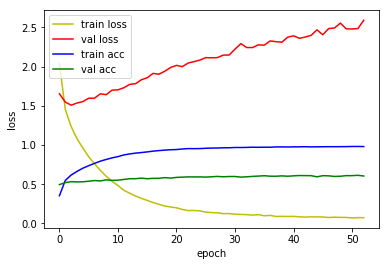

4815/4815 [==============================] - 3s 559us/sample - loss: 1.5901 - acc: 0.5009
Loss: 1.5901038102519351 Accuracy: 0.5009346

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8793 - acc: 0.3954
Epoch 00001: val_loss improved from inf to 1.47811, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_4_conv_checkpoint/001-1.4781.hdf5
36805/36805 [==============================] - 50s 1ms/sample - loss: 1.8791 - acc: 0.3955 - val_loss: 1.4781 - val_acc: 0.5465
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3848 - acc: 0.5701
Epoch 00002: val_loss improved from 1.47811 to 1.30199, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_4_conv_checkpoint/002-1.3020.hdf5
36805/36805 [==============================] - 48s 1ms/sample - loss: 1.3847 - acc: 0.5701 - val_loss: 1.3020 - val_acc: 0.6108
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.1871

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1973 - acc: 0.9455
Epoch 00028: val_loss did not improve from 1.13917
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.1973 - acc: 0.9455 - val_loss: 1.2572 - val_acc: 0.6937
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1806 - acc: 0.9500
Epoch 00029: val_loss did not improve from 1.13917
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.1806 - acc: 0.9500 - val_loss: 1.2681 - val_acc: 0.6951
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1788 - acc: 0.9518
Epoch 00030: val_loss did not improve from 1.13917
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.1788 - acc: 0.9518 - val_loss: 1.2733 - val_acc: 0.6981
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1683 - acc: 0.9539
Epoch 00031: val_loss did not improve from 1.13917
36805/36805 [===========

Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0873 - acc: 0.9767
Epoch 00058: val_loss did not improve from 1.13917
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.0873 - acc: 0.9767 - val_loss: 1.4085 - val_acc: 0.7195

1D_CNN_custom_tanh_DO_4_conv Model


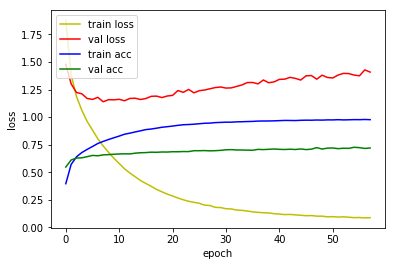

4815/4815 [==============================] - 3s 594us/sample - loss: 1.1904 - acc: 0.6422
Loss: 1.1904275558695492 Accuracy: 0.64215994

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8785 - acc: 0.3927
Epoch 00001: val_loss improved from inf to 1.50087, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_5_conv_checkpoint/001-1.5009.hdf5
36805/36805 [==============================] - 52s 1ms/sample - loss: 1.8785 - acc: 0.3926 - val_loss: 1.5009 - val_acc: 0.5239
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4125 - acc: 0.5590
Epoch 00002: val_loss improved from 1.50087 to 1.31584, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_5_conv_checkpoint/002-1.3158.hdf5
36805/36805 [==============================] - 50s 1ms/sample - loss: 1.4124 - acc: 0.5591 - val_loss: 1.3158 - val_acc: 0.6000
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.225

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3230 - acc: 0.9080
Epoch 00025: val_loss did not improve from 0.81165
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.3230 - acc: 0.9080 - val_loss: 0.8306 - val_acc: 0.7589
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3026 - acc: 0.9159
Epoch 00026: val_loss did not improve from 0.81165
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.3025 - acc: 0.9159 - val_loss: 0.8285 - val_acc: 0.7661
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2929 - acc: 0.9160
Epoch 00027: val_loss did not improve from 0.81165
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.2929 - acc: 0.9160 - val_loss: 0.8405 - val_acc: 0.7682
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2761 - acc: 0.9235
Epoch 00028: val_loss did not improve from 0.81165
36805/36805 [===========

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1079 - acc: 0.9715
Epoch 00055: val_loss did not improve from 0.81165
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.1079 - acc: 0.9716 - val_loss: 0.9407 - val_acc: 0.7708
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0994 - acc: 0.9743
Epoch 00056: val_loss did not improve from 0.81165
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.0995 - acc: 0.9742 - val_loss: 0.9685 - val_acc: 0.7727
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1296 - acc: 0.9681
Epoch 00057: val_loss did not improve from 0.81165
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.1296 - acc: 0.9681 - val_loss: 0.9393 - val_acc: 0.7775
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0960 - acc: 0.9751
Epoch 00058: val_loss did not improve from 0.81165
36805/36805 [===========

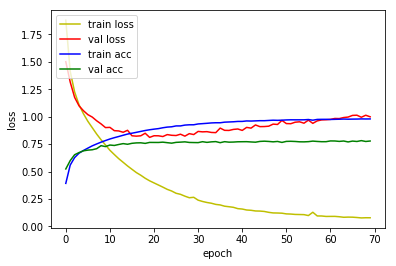

4815/4815 [==============================] - 3s 626us/sample - loss: 0.8895 - acc: 0.7429
Loss: 0.8895337905591646 Accuracy: 0.74288684

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9172 - acc: 0.3724
Epoch 00001: val_loss improved from inf to 1.45125, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_6_conv_checkpoint/001-1.4512.hdf5
36805/36805 [==============================] - 54s 1ms/sample - loss: 1.9171 - acc: 0.3725 - val_loss: 1.4512 - val_acc: 0.5395
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4531 - acc: 0.5390
Epoch 00002: val_loss improved from 1.45125 to 1.28225, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_6_conv_checkpoint/002-1.2822.hdf5
36805/36805 [==============================] - 51s 1ms/sample - loss: 1.4530 - acc: 0.5390 - val_loss: 1.2822 - val_acc: 0.6101
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.291

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.5052 - acc: 0.8510
Epoch 00024: val_loss improved from 0.56732 to 0.54712, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_6_conv_checkpoint/024-0.5471.hdf5
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.5054 - acc: 0.8510 - val_loss: 0.5471 - val_acc: 0.8437
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4947 - acc: 0.8528
Epoch 00025: val_loss did not improve from 0.54712
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.4947 - acc: 0.8528 - val_loss: 0.5602 - val_acc: 0.8444
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4868 - acc: 0.8569
Epoch 00026: val_loss improved from 0.54712 to 0.54325, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_6_conv_checkpoint/026-0.5432.hdf5
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.4868 - acc: 0.8569 - val_loss: 0.5432 - 

Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2763 - acc: 0.9168
Epoch 00051: val_loss did not improve from 0.48052
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.2763 - acc: 0.9168 - val_loss: 0.4925 - val_acc: 0.8698
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2725 - acc: 0.9185
Epoch 00052: val_loss improved from 0.48052 to 0.47932, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_6_conv_checkpoint/052-0.4793.hdf5
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.2724 - acc: 0.9185 - val_loss: 0.4793 - val_acc: 0.8712
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2647 - acc: 0.9211
Epoch 00053: val_loss improved from 0.47932 to 0.45959, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_6_conv_checkpoint/053-0.4596.hdf5
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.2647 - acc: 0.9211 - val_loss: 0.4596 - 

Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1624 - acc: 0.9491
Epoch 00080: val_loss did not improve from 0.45941
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.1624 - acc: 0.9491 - val_loss: 0.5007 - val_acc: 0.8812
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1583 - acc: 0.9518
Epoch 00081: val_loss did not improve from 0.45941
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.1583 - acc: 0.9518 - val_loss: 0.4982 - val_acc: 0.8786
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1599 - acc: 0.9513
Epoch 00082: val_loss did not improve from 0.45941
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.1599 - acc: 0.9513 - val_loss: 0.4803 - val_acc: 0.8791
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1577 - acc: 0.9520
Epoch 00083: val_loss did not improve from 0.45941
36805/36805 [===========

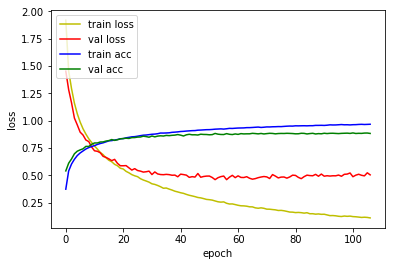

4815/4815 [==============================] - 3s 596us/sample - loss: 0.5498 - acc: 0.8474
Loss: 0.5498361694726122 Accuracy: 0.847352

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9706 - acc: 0.3595
Epoch 00001: val_loss improved from inf to 1.43462, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_7_conv_checkpoint/001-1.4346.hdf5
36805/36805 [==============================] - 55s 1ms/sample - loss: 1.9705 - acc: 0.3595 - val_loss: 1.4346 - val_acc: 0.5602
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4727 - acc: 0.5340
Epoch 00002: val_loss improved from 1.43462 to 1.21566, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_7_conv_checkpoint/002-1.2157.hdf5
36805/36805 [==============================] - 51s 1ms/sample - loss: 1.4726 - acc: 0.5340 - val_loss: 1.2157 - val_acc: 0.6320
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2491 

36800/36805 [============================>.] - ETA: 0s - loss: 0.3643 - acc: 0.8960
Epoch 00023: val_loss improved from 0.33088 to 0.32686, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_7_conv_checkpoint/023-0.3269.hdf5
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.3643 - acc: 0.8960 - val_loss: 0.3269 - val_acc: 0.9096
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3531 - acc: 0.8982
Epoch 00024: val_loss did not improve from 0.32686
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.3531 - acc: 0.8981 - val_loss: 0.3271 - val_acc: 0.9096
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3417 - acc: 0.9002
Epoch 00025: val_loss improved from 0.32686 to 0.31267, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_7_conv_checkpoint/025-0.3127.hdf5
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.3417 - acc: 0.9002 - val_loss: 0.3127 - val_acc: 0.91

Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2084 - acc: 0.9365
Epoch 00049: val_loss improved from 0.24795 to 0.23845, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_7_conv_checkpoint/049-0.2384.hdf5
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.2084 - acc: 0.9365 - val_loss: 0.2384 - val_acc: 0.9369
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2024 - acc: 0.9404
Epoch 00050: val_loss improved from 0.23845 to 0.23126, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_7_conv_checkpoint/050-0.2313.hdf5
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.2024 - acc: 0.9404 - val_loss: 0.2313 - val_acc: 0.9345
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1973 - acc: 0.9413
Epoch 00051: val_loss did not improve from 0.23126
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.1973 - acc: 0.9413 - val_loss: 0.2426 - 

Epoch 77/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1251 - acc: 0.9613
Epoch 00077: val_loss did not improve from 0.22770
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.1251 - acc: 0.9613 - val_loss: 0.2349 - val_acc: 0.9357
Epoch 78/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1257 - acc: 0.9616
Epoch 00078: val_loss did not improve from 0.22770
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.1258 - acc: 0.9616 - val_loss: 0.2417 - val_acc: 0.9371
Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1260 - acc: 0.9596
Epoch 00079: val_loss improved from 0.22770 to 0.22326, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_7_conv_checkpoint/079-0.2233.hdf5
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.1261 - acc: 0.9596 - val_loss: 0.2233 - val_acc: 0.9406
Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.

Epoch 106/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0881 - acc: 0.9721
Epoch 00106: val_loss did not improve from 0.21809
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0880 - acc: 0.9722 - val_loss: 0.2482 - val_acc: 0.9404
Epoch 107/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0821 - acc: 0.9743
Epoch 00107: val_loss did not improve from 0.21809
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0825 - acc: 0.9743 - val_loss: 0.2352 - val_acc: 0.9425
Epoch 108/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0823 - acc: 0.9746
Epoch 00108: val_loss did not improve from 0.21809
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0823 - acc: 0.9747 - val_loss: 0.2351 - val_acc: 0.9429
Epoch 109/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0787 - acc: 0.9757
Epoch 00109: val_loss did not improve from 0.21809
36805/36805 [=======


1D_CNN_custom_tanh_DO_7_conv Model


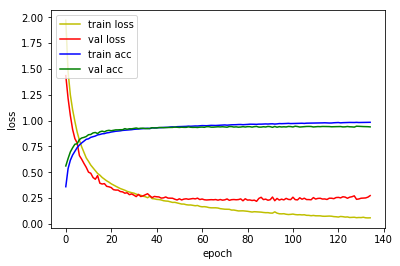

4815/4815 [==============================] - 3s 634us/sample - loss: 0.2675 - acc: 0.9173
Loss: 0.26745054775371235 Accuracy: 0.91734165

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9800 - acc: 0.3546
Epoch 00001: val_loss improved from inf to 1.41437, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_8_conv_checkpoint/001-1.4144.hdf5
36805/36805 [==============================] - 56s 2ms/sample - loss: 1.9800 - acc: 0.3546 - val_loss: 1.4144 - val_acc: 0.5768
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4170 - acc: 0.5518
Epoch 00002: val_loss improved from 1.41437 to 1.09531, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_8_conv_checkpoint/002-1.0953.hdf5
36805/36805 [==============================] - 52s 1ms/sample - loss: 1.4169 - acc: 0.5518 - val_loss: 1.0953 - val_acc: 0.6881
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.14

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2047 - acc: 0.9405
Epoch 00023: val_loss did not improve from 0.17333
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.2047 - acc: 0.9405 - val_loss: 0.1776 - val_acc: 0.9490
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1966 - acc: 0.9437
Epoch 00024: val_loss did not improve from 0.17333
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.1966 - acc: 0.9437 - val_loss: 0.1863 - val_acc: 0.9495
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1894 - acc: 0.9448
Epoch 00025: val_loss improved from 0.17333 to 0.16321, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_8_conv_checkpoint/025-0.1632.hdf5
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.1893 - acc: 0.9448 - val_loss: 0.1632 - val_acc: 0.9532
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.

Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0909 - acc: 0.9714
Epoch 00050: val_loss did not improve from 0.14533
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0909 - acc: 0.9714 - val_loss: 0.1524 - val_acc: 0.9595
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0883 - acc: 0.9742
Epoch 00051: val_loss did not improve from 0.14533
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.0883 - acc: 0.9742 - val_loss: 0.1563 - val_acc: 0.9557
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0888 - acc: 0.9745
Epoch 00052: val_loss did not improve from 0.14533
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.0888 - acc: 0.9745 - val_loss: 0.1578 - val_acc: 0.9574
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0841 - acc: 0.9748
Epoch 00053: val_loss did not improve from 0.14533
36805/36805 [===========

36800/36805 [============================>.] - ETA: 0s - loss: 0.0414 - acc: 0.9885
Epoch 00079: val_loss did not improve from 0.14076
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.0414 - acc: 0.9885 - val_loss: 0.1790 - val_acc: 0.9548
Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0420 - acc: 0.9884
Epoch 00080: val_loss did not improve from 0.14076
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.0420 - acc: 0.9884 - val_loss: 0.1512 - val_acc: 0.9604
Epoch 81/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0405 - acc: 0.9883
Epoch 00081: val_loss did not improve from 0.14076
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.0405 - acc: 0.9883 - val_loss: 0.1708 - val_acc: 0.9592
Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0442 - acc: 0.9869
Epoch 00082: val_loss did not improve from 0.14076
36805/36805 [========================

Epoch 109/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0265 - acc: 0.9924
Epoch 00109: val_loss did not improve from 0.14076
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.0265 - acc: 0.9924 - val_loss: 0.1950 - val_acc: 0.9553

1D_CNN_custom_tanh_DO_8_conv Model


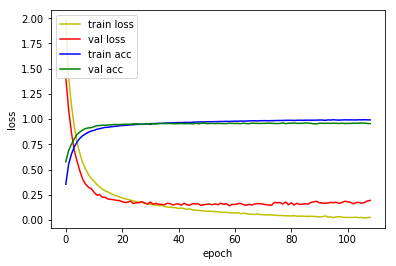

4815/4815 [==============================] - 3s 657us/sample - loss: 0.1836 - acc: 0.9452
Loss: 0.183581630432222 Accuracy: 0.94517136

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6067 - acc: 0.4963
Epoch 00001: val_loss improved from inf to 0.91797, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_9_conv_checkpoint/001-0.9180.hdf5
36805/36805 [==============================] - 58s 2ms/sample - loss: 1.6068 - acc: 0.4963 - val_loss: 0.9180 - val_acc: 0.7282
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8523 - acc: 0.7440
Epoch 00002: val_loss improved from 0.91797 to 0.57724, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_9_conv_checkpoint/002-0.5772.hdf5
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.8523 - acc: 0.7440 - val_loss: 0.5772 - val_acc: 0.8383
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.6027

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0917 - acc: 0.9728
Epoch 00024: val_loss improved from 0.12882 to 0.12668, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_9_conv_checkpoint/024-0.1267.hdf5
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.0917 - acc: 0.9728 - val_loss: 0.1267 - val_acc: 0.9618
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0853 - acc: 0.9749
Epoch 00025: val_loss improved from 0.12668 to 0.12601, saving model to model/checkpoint/1D_CNN_custom_tanh_DO_9_conv_checkpoint/025-0.1260.hdf5
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.0853 - acc: 0.9749 - val_loss: 0.1260 - val_acc: 0.9618
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0851 - acc: 0.9741
Epoch 00026: val_loss did not improve from 0.12601
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.0851 - acc: 0.9741 - val_loss: 0.1269 - 

Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0232 - acc: 0.9934
Epoch 00052: val_loss did not improve from 0.11929
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.0232 - acc: 0.9934 - val_loss: 0.1383 - val_acc: 0.9655
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0196 - acc: 0.9950
Epoch 00053: val_loss did not improve from 0.11929
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.0196 - acc: 0.9950 - val_loss: 0.1518 - val_acc: 0.9613
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0201 - acc: 0.9950
Epoch 00054: val_loss did not improve from 0.11929
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.0201 - acc: 0.9950 - val_loss: 0.1307 - val_acc: 0.9644
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0220 - acc: 0.9940
Epoch 00055: val_loss did not improve from 0.11929
36805/36805 [===========

Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0086 - acc: 0.9977
Epoch 00082: val_loss did not improve from 0.11929
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.0086 - acc: 0.9977 - val_loss: 0.1681 - val_acc: 0.9620
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0078 - acc: 0.9980
Epoch 00083: val_loss did not improve from 0.11929
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.0078 - acc: 0.9980 - val_loss: 0.1556 - val_acc: 0.9658

1D_CNN_custom_tanh_DO_9_conv Model


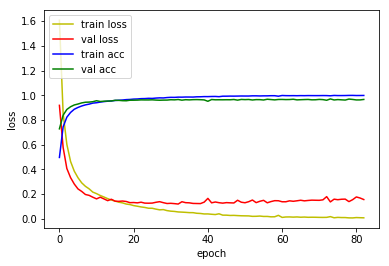

4815/4815 [==============================] - 3s 672us/sample - loss: 0.1752 - acc: 0.9485
Loss: 0.1751945678535404 Accuracy: 0.9484943



In [10]:
for i in range(1, 10):
    base = '1D_CNN_custom_tanh_DO'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_DO(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [13]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_tanh_DO'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(1, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_tanh_DO_1_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
flatten_9 (Flatten)          (None, 1024000)           0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024000)           0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                16384016  
Total params: 16,384,400
Trainable params: 16,384,400
Non-trainable params: 0
_________________________________________________________________
4815/4815 [==============================] - 2s 513us/sample - loss: 2.7258 - acc: 0.0993
Loss: 2.7257815188707966 Accuracy: 0.09927311

1D_CNN_custom_tanh_DO_2_conv Model
______________________________________________________

4815/4815 [==============================] - 4s 815us/sample - loss: 0.5498 - acc: 0.8474
Loss: 0.5498361694726122 Accuracy: 0.847352

1D_CNN_custom_tanh_DO_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_66 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
conv1d_67 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
max_pooling1d_51 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_68 (Conv1D)           (None, 5333, 64)          20544     
_________________________________________________________________
max_pooling1d_52 (MaxPooling (None, 1777, 64)          0         
_________________________________________________________________
conv1d_69 (Conv1D)           (None, 17

4815/4815 [==============================] - 4s 856us/sample - loss: 0.1752 - acc: 0.9485
Loss: 0.1751945678535404 Accuracy: 0.9484943


In [14]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
# base = '1D_CNN_custom_tanh_DO'

with open(path.join(log_dir, base+'_last'), 'w') as log_file:
    for i in range(1, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + '000_last.hdf5'

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_tanh_DO_1_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
flatten_9 (Flatten)          (None, 1024000)           0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024000)           0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                16384016  
Total params: 16,384,400
Trainable params: 16,384,400
Non-trainable params: 0
_________________________________________________________________
4815/4815 [==============================] - 3s 574us/sample - loss: 8.1900 - acc: 0.0970
Loss: 8.190012983023069 Accuracy: 0.09698857

1D_CNN_custom_tanh_DO_2_conv Model
_______________________________________________________

4815/4815 [==============================] - 4s 848us/sample - loss: 0.5991 - acc: 0.8492
Loss: 0.5990967267522683 Accuracy: 0.84922117

1D_CNN_custom_tanh_DO_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_66 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
conv1d_67 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
max_pooling1d_51 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_68 (Conv1D)           (None, 5333, 64)          20544     
_________________________________________________________________
max_pooling1d_52 (MaxPooling (None, 1777, 64)          0         
_________________________________________________________________
conv1d_69 (Conv1D)           (None, 

4815/4815 [==============================] - 5s 938us/sample - loss: 0.2030 - acc: 0.9558
Loss: 0.20299070183601645 Accuracy: 0.9557632
